## MOVIE RECOMMENDATION


MovieLens
GroupLens Research has collected and made available rating data sets from the MovieLens web site (http://movielens.org). The data sets were collected over various periods of time, depending on the size of the set.

Small: 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. Last updated 9/2018.

# NOTE -there are larger data set available online.
 The smaller dataset is used in order to complete the process under the constraint of Personal Laoptop or PC.
 larger datasets-https://grouplens.org/datasets/movielens/

The performance metrics will significantly improve on using larger dataset.

Objectives:
1. Predict the rating that a user would give to a movie that he ahs not yet rated.
2. Minimize the difference between predicted and actual rating (RMSE and MAPE)
<br>

Constraints:
1. Some form of interpretability.

<h3>  Type of Machine Learning Problem </h3>

<pre>
For a given movie and user we need to predict the rating would be given by him/her to the movie. 
The given problem is a Recommendation problem 
It can also seen as a Regression problem 
</pre>

<h3>  Machine Learning Objective and Constraints </h3>

1. Minimize RMSE.
2. Try to provide some interpretability.

In [0]:

from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h1>Exploratory Data Analysis </h1>

<h2>  Preprocessing</h2> 

In [0]:
dfmov=pd.read_csv("/content/drive/My Drive/Colab Notebooks/rec/movies.csv")

In [0]:
dfmov.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [0]:
dfratings=pd.read_csv("/content/drive/My Drive/Colab Notebooks/rec/ratings.csv")

In [0]:
dfratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [0]:
dfratings["rating"].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

#checking for null values

In [0]:
print("no of null values",sum(dfratings.isnull().any()))

no of null values 0


# Removing duplicates

In [0]:
duplicate = dfratings.duplicated(['userId','movieId','rating'])
dupsum = sum(duplicate) # by considering all columns..( including timestamp)
print("The the no duplicate rating entries in the data..",(dupsum))

The the no duplicate rating entries in the data.. 0


#Stats

In [0]:
print("\nTotal no of ratings :",dfratings.shape[0])
print("Total No of Users   :", len(np.unique(dfratings.userId)))
print("Total No of movies  :", len(np.unique(dfratings.movieId)))


Total no of ratings : 100836
Total No of Users   : 610
Total No of movies  : 9724


#Splitting Data

In [0]:
if not os.path.isfile('trainmov1.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    dfratings.iloc[:int(dfratings.shape[0]*0.50)].to_csv("trainmov1.csv", index=False)

if not os.path.isfile('testmov1.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    dfratings.iloc[int(dfratings.shape[0]*0.50):int(dfratings.shape[0]*0.75)].to_csv("testmov1.csv", index=False)

train_df = pd.read_csv("trainmov1.csv", parse_dates=['timestamp'])
test_df = pd.read_csv("testmov1.csv")

In [0]:
train_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [0]:
test_df.head()

,userId,movieId,rating,timestamp
0,325,4085,3.0,1039396588
1,325,4086,3.0,1039399558
2,325,4117,4.0,1039398807
3,325,4226,4.0,1039399325
4,325,4239,4.0,1039397868


In [0]:
print("Training data ")
print("-"*50)
print("\nTotal no of ratings :",train_df.shape[0])
print("Total No of Users   :", len(np.unique(train_df.userId)))
print("Total No of movies  :", len(np.unique(train_df.movieId)))

Training data 
--------------------------------------------------

Total no of ratings : 50418
Total No of Users   : 325
Total No of movies  : 6920


In [0]:
print("Test data ")
print("-"*50)
print("\nTotal no of ratings :",test_df.shape[0])
print("Total No of Users   :", len(np.unique(test_df.userId)))
print("Total No of movies  :", len(np.unique(test_df.movieId)))

Test data 
--------------------------------------------------

Total no of ratings : 25209
Total No of Users   : 153
Total No of movies  : 6152


In [0]:
# method to make y-axis more readable
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

#Distribution of rating

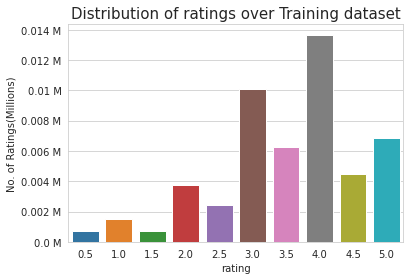

In [0]:
%matplotlib inline
fig, ax = plt.subplots()
plt.title('Distribution of ratings over Training dataset', fontsize=15)
sns.countplot(train_df.rating)
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(Millions)')

plt.show()

#Analysis on the Ratings given by user 

In [0]:
no_of_rated_movies_per_user = train_df.groupby(by='userId')['rating'].count().sort_values(ascending=False)

no_of_rated_movies_per_user.head()

userId
274    1346
68     1260
288    1055
249    1046
182     977
Name: rating, dtype: int64

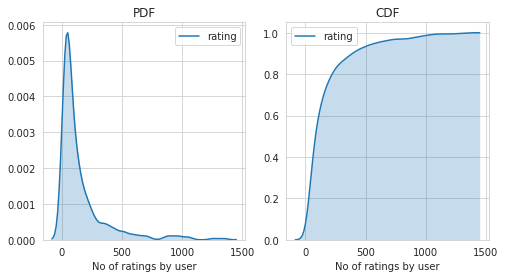

In [0]:



import statsmodels
import statsmodels.nonparametric.api as smnp
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')

plt.show()

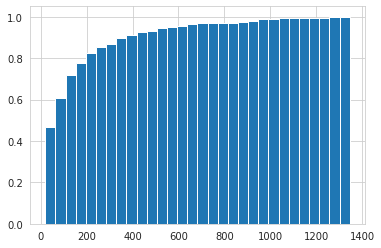

In [0]:
plt.hist(no_of_rated_movies_per_user,cumulative=True, density=True, bins=30)
plt.show()

In [0]:
no_of_rated_movies_per_user.describe()

count     325.000000
mean      155.132308
std       209.175375
min        20.000000
25%        35.000000
50%        71.000000
75%       176.000000
max      1346.000000
Name: rating, dtype: float64

In [0]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

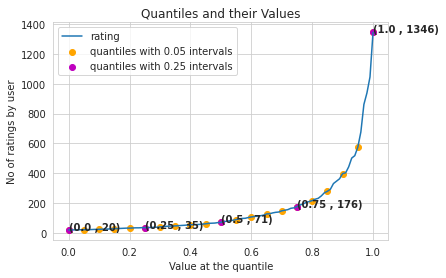

In [0]:
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')

# annotate the 25th, 50th, 75th and 100th percentile values....
for x,y in zip(quantiles.index[::25], quantiles[::25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y)
                ,fontweight='bold')


plt.show()

In [0]:
quantiles[::5]

0.00      20
0.05      22
0.10      24
0.15      28
0.20      32
0.25      35
0.30      40
0.35      47
0.40      54
0.45      61
0.50      71
0.55      89
0.60     107
0.65     127
0.70     148
0.75     176
0.80     217
0.85     279
0.90     398
0.95     575
1.00    1346
Name: rating, dtype: int64

In [0]:
no_of_rated_movies_per_user=pd.DataFrame(no_of_rated_movies_per_user)

In [0]:
#???
print('\n No of ratings at last 5 percentile : {}\n'.format(sum(no_of_rated_movies_per_user["rating"]>=600)) )


 No of ratings at last 5 percentile : 16



#Analysis of ratings of a movie given by a user

<IPython.core.display.Javascript object>

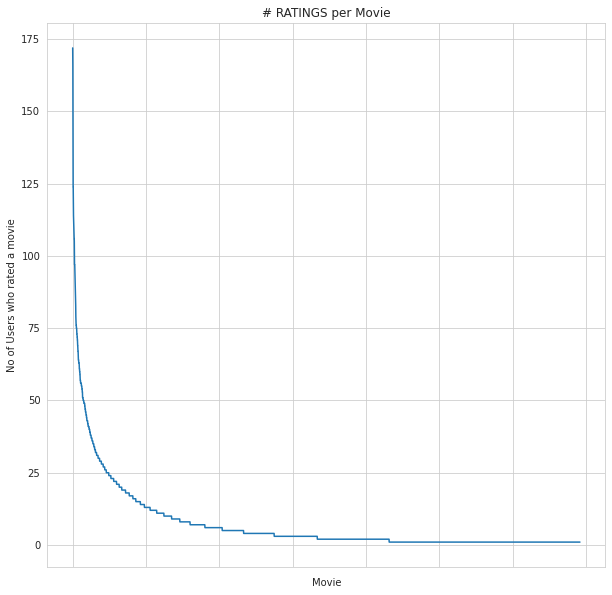

In [0]:
matplotlib.use('nbagg')
no_of_ratings_per_movie = train_df.groupby(by='movieId')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=(10,10))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('# RATINGS per Movie')
plt.xlabel('Movie')
plt.ylabel('No of Users who rated a movie')
ax.set_xticklabels([])

plt.show()

In [0]:

train_df.userId.unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [0]:
len(train_df.userId.unique())

325

In [0]:
train_df.movieId.unique()

array([   1,    3,    6, ..., 2425, 2848, 2894])

In [0]:
len(train_df.movieId.unique())

6920

#Sparse matrix train data

In [0]:
start = datetime.now()
if os.path.isfile('/content/drive/My Drive/Colab Notebooks/rec/train_sparse_matrix2.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    train_sparse_matrix = sparse.load_npz('/content/drive/My Drive/Colab Notebooks/rec/train_sparse_matrix1.npz')
    print('Done. It\'s shape is : (user, movie) : ',train_sparse_matrix.shape)
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    train_sparse_matrix = sparse.csr_matrix((train_df.rating.values, (train_df.userId.values,
                                               train_df.movieId.values),))
    
    print('Done. It\'s shape is : (user, movie) : ',train_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz("/content/drive/My Drive/Colab Notebooks/rec/train_sparse_matrix1.npz", train_sparse_matrix)
    print('Done..\n')

print(datetime.now() - start)

We are creating sparse_matrix from the dataframe..
Done. It's shape is : (user, movie) :  (326, 193588)
Saving it into disk for furthur usage..
Done..

0:00:00.052467


In [0]:
train_sparse_matrix

<326x193588 sparse matrix of type '<class 'numpy.float64'>'
	with 50418 stored elements in Compressed Sparse Row format>

In [0]:
len(train_df.movieId.values)

50418

In [0]:
len(train_df.userId.values)

50418

# sparsity

In [0]:
us,mv = train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()

print("Sparsity Of Train matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Train matrix : 99.9201105224922 % 


#Sparse matrix for test data set

In [0]:
start = datetime.now()
if os.path.isfile('/content/drive/My Drive/Colab Notebooks/rec/test_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    test_sparse_matrix = sparse.load_npz('/content/drive/My Drive/Colab Notebooks/rec/test_sparse_matrix.npz')
    print("DONE..")
    print('Done. It\'s shape is : (user, movie) : ',test_sparse_matrix.shape)
else: 
    print("We are creating sparse_matrix from the dataframe..")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    test_sparse_matrix = sparse.csr_matrix((test_df.rating.values, (test_df.userId.values,
                                               test_df.movieId.values)))
    
    print('Done. It\'s shape is : (user, movie) : ',test_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz("/content/drive/My Drive/Colab Notebooks/rec/test_sparse_matrix.npz", test_sparse_matrix)
    print('Done..\n')
    
print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
Done. It's shape is : (user, movie) :  (478, 193610)
0:00:00.011458


In [0]:
test_sparse_matrix

<478x193610 sparse matrix of type '<class 'numpy.float64'>'
	with 25209 stored elements in Compressed Sparse Row format>

In [0]:
us,mv = test_sparse_matrix.shape
elem = test_sparse_matrix.count_nonzero()

print("Sparsity Of Test matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Test matrix : 99.97276044949959 % 


#Finding Global average of all movie ratings, Average rating per user, and Average rating per movie


In [0]:

def get_average_ratings(sparse_matrix, of_users):
    
    # average ratings of user/axes
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    # no of ratings that each user OR movie..
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # max_user  and max_movie ids in sparse matrix 
    u,m = sparse_matrix.shape
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    # return that dictionary of average ratings
    return average_ratings

Global average

In [0]:
train_averages = dict()
# get the global average of ratings in our train set.
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
train_averages

{'global': 3.5228093141338412}

Average rating of user

In [0]:
train_averages['user'] = get_average_ratings(train_sparse_matrix, of_users=True)
print('\nAverage rating of user 10 :',train_averages['user'][10])


Average rating of user 10 : 3.2785714285714285


Average rating of movies

In [0]:
train_averages['movie'] =  get_average_ratings(train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 15 :',train_averages['movie'][15])


 AVerage rating of movie 15 : 3.5


#PDF AND CDF

<IPython.core.display.Javascript object>

0:00:00.562713


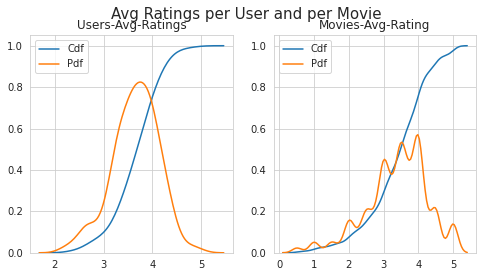

In [0]:
start = datetime.now()
# draw pdfs for average rating per user and average
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.5))
fig.suptitle('Avg Ratings per User and per Movie', fontsize=15)

ax1.set_title('Users-Avg-Ratings')
# get the list of average user ratings from the averages dictionary..
user_averages = [rat for rat in train_averages['user'].values()]
sns.distplot(user_averages, ax=ax1, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
sns.distplot(user_averages, ax=ax1, hist=False,label='Pdf')

ax2.set_title('Movies-Avg-Rating')
# get the list of movie_average_ratings from the dictionary..
movie_averages = [rat for rat in train_averages['movie'].values()]
sns.distplot(movie_averages, ax=ax2, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
sns.distplot(movie_averages, ax=ax2, hist=False, label='Pdf')

plt.show()
print(datetime.now() - start)

#COLD START PROBLEM

In [0]:
total_users = len(np.unique(dfratings.userId))
users_train = len(train_averages['user'])
new_users = total_users - users_train

print('\nTotal number of Users  :', total_users)
print('\nNumber of Users in Train data :', users_train)
print("\nNo of Users that didn't appear in train data: {}({} %) \n ".format(new_users,
                                                                        np.round((new_users/total_users)*100, 2)))


Total number of Users  : 610

Number of Users in Train data : 325

No of Users that didn't appear in train data: 285(46.72 %) 
 


In [0]:
total_movies = len(np.unique(dfratings.movieId))
movies_train = len(train_averages['movie'])
new_movies = total_movies - movies_train

print('\nTotal number of Movies  :', total_movies)
print('\nNumber of movies in Train data :', movies_train)
print("\nNo of Movies that didn't appear in train data: {}({} %) \n ".format(new_movies,
                                                                        np.round((new_movies/total_movies)*100, 2)))


Total number of Movies  : 9724

Number of movies in Train data : 6920

No of Movies that didn't appear in train data: 2804(28.84 %) 
 


# Similarty matrix

In [0]:
from sklearn.metrics.pairwise import cosine_similarity


def compute_user_similarity(sparse_matrix, compute_for_few=False, top = 100, verbose=False, verb_for_n_rows = 20,
                            draw_time_taken=True):
    no_of_users, _ = sparse_matrix.shape
    # get the indices of  non zero rows(users) from our sparse matrix
    row_ind, col_ind = sparse_matrix.nonzero()
    row_ind = sorted(set(row_ind)) # we don't have to
    time_taken = list() #  time taken for finding similar users for an user..
    
    # we create rows, cols, and data lists.., which can be used to create sparse matrices
    rows, cols, data = list(), list(), list()
    if verbose: print("Computing top",top,"similarities for each user..")
    
    start = datetime.now()
    temp = 0
    
    for row in row_ind[:top] if compute_for_few else row_ind:
        temp = temp+1
        prev = datetime.now()
        
        # get the similarity row for this user with all other users
        sim = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
        # We will get only the top ''top'' most similar users and ignore rest of them..
        top_sim_ind = sim.argsort()[-top:]
        top_sim_val = sim[top_sim_ind]
        
        # add them to our rows, cols and data
        rows.extend([row]*top)
        cols.extend(top_sim_ind)
        data.extend(top_sim_val)
        time_taken.append(datetime.now().timestamp() - prev.timestamp())
        if verbose:
            if temp%verb_for_n_rows == 0:
                print("computing done for {} users [  time elapsed : {}  ]"
                      .format(temp, datetime.now()-start))
            
        
    # lets create sparse matrix out of these and return it
    if verbose: print('Creating Sparse matrix from the computed similarities')
    #return rows, cols, data
    
    if draw_time_taken:
        plt.plot(time_taken, label = 'time taken for each user')
        plt.plot(np.cumsum(time_taken), label='Total time')
        plt.legend(loc='best')
        plt.xlabel('User')
        plt.ylabel('Time (seconds)')
        plt.show()
        
    return sparse.csr_matrix((data, (rows, cols)), shape=(no_of_users, no_of_users)), time_taken      

Computing top 100 similarities for each user..
computing done for 20 users [  time elapsed : 0:00:00.042464  ]
computing done for 40 users [  time elapsed : 0:00:00.083305  ]
computing done for 60 users [  time elapsed : 0:00:00.129919  ]
computing done for 80 users [  time elapsed : 0:00:00.175639  ]
computing done for 100 users [  time elapsed : 0:00:00.225945  ]
Creating Sparse matrix from the computed similarities


<IPython.core.display.Javascript object>

----------------------------------------------------------------------------------------------------
Time taken : 0:00:00.281248


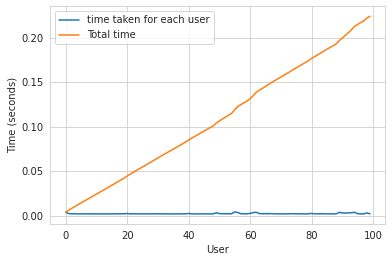

In [0]:
start = datetime.now()
u_u_sim_sparse, _ = compute_user_similarity(train_sparse_matrix, compute_for_few=True, top = 100,
                                                     verbose=True)
print("-"*100)
print("Time taken :",datetime.now()-start)

#Movie movie similarity

In [0]:
start = datetime.now()
if not os.path.isfile('m_m_sim_sparse1.npz'):
    print("It seems you don't have that file. Computing movie_movie similarity...")
    start = datetime.now()
    m_m_sim_sparse = cosine_similarity(X=train_sparse_matrix.T, dense_output=False)
    print("Done..")
    # store this sparse matrix in disk before using it. For future purposes.
    print("Saving it to disk without the need of re-computing it again.. ")
    sparse.save_npz("m_m_sim_sparse1.npz", m_m_sim_sparse)
    print("Done..")
else:
    print("It is there, We will get it.")
    m_m_sim_sparse = sparse.load_npz("m_m_sim_sparse1.npz")
    print("Done ...")

print("It's a ",m_m_sim_sparse.shape," dimensional matrix")

print(datetime.now() - start)

It is there, We will get it.
Done ...
It's a  (193588, 193588)  dimensional matrix
0:00:01.409432


In [0]:
m_m_sim_sparse

<193588x193588 sparse matrix of type '<class 'numpy.float64'>'
	with 10683914 stored elements in Compressed Sparse Row format>

In [0]:
m_m_sim_sparse.shape

(193588, 193588)

In [0]:
movie_ids = np.unique(m_m_sim_sparse.nonzero()[1])

In [0]:
movie_ids.shape

(6920,)

In [0]:
start = datetime.now()
similar_movies = dict()
for movie in movie_ids:
    # get the top similar movies and store them in the dictionary
    sim_movies = m_m_sim_sparse[movie].toarray().ravel().argsort()[::-1][1:]
    similar_movies[movie] = sim_movies[:100]
print(datetime.now() - start)

# just testing similar movies for movie_15
similar_movies[15]

0:00:33.884636


array([ 340,  704,  274,  195,   93,  637,  267,   54,  291,  177,  258,
        276,  468,  248,  450,  611,   92,  359,  219,  240,  336,  243,
        662, 1006,  254,  352,  279,  979,  835,  536,  201,  189, 2103,
        510,  313,  795,  310,  775,  179,  209,  460,  867,  252,  207,
        881,  437,  415,  191,  304, 1606,  416,  216,  491,  552,  256,
        434,  210, 2822,  355,  158,  173,  251,  250,  700, 1049,  339,
        432,  168,  273,  367,  333,  558,  350,  606,   43,  378,  338,
        440,   95,  174,  353,  237,   86,  275,  212,  327,  435,  472,
        349,  329,  426,   61,  667,  270,  891,  981,  196,  351,  888,
       2153])

In [0]:
dfmov.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [0]:
movie_titles=dfmov

#Finding similar movie for JUMANJI

In [0]:
mv_id = 1

print("\nMovie ----->",movie_titles.loc[mv_id].values[1])

print("\nIt has {} Ratings from users.".format(train_sparse_matrix[:,mv_id].getnnz()))

print("\nWe have {} movies which are similarto this  and we will get only top most..".format(m_m_sim_sparse[:,mv_id].getnnz()))


Movie -----> Jumanji (1995)

It has 117 Ratings from users.

We have 5561 movies which are similarto this  and we will get only top most..


In [0]:
similarities = m_m_sim_sparse[mv_id].toarray().ravel()

similar_indices = similarities.argsort()[::-1][1:]

similarities[similar_indices]

sim_indices = similarities.argsort()[::-1][1:] 

<IPython.core.display.Javascript object>

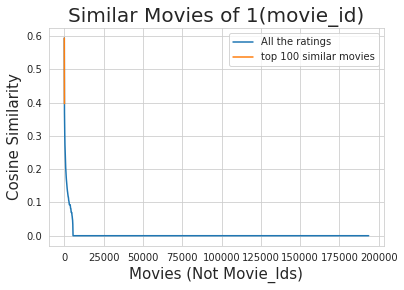

In [0]:
plt.plot(similarities[sim_indices], label='All the ratings')
plt.plot(similarities[sim_indices[:100]], label='top 100 similar movies')
plt.title("Similar Movies of {}(movie_id)".format(mv_id), fontsize=20)
plt.xlabel("Movies (Not Movie_Ids)", fontsize=15)
plt.ylabel("Cosine Similarity",fontsize=15)
plt.legend()
plt.show()

AS YOU CAN SEE THE MOVIE ARE QUITE SIMILAR TO JUMANJI

In [0]:
movie_titles.loc[sim_indices[:10]]

,movieId,title,genres
780,1022,Cinderella (1950),Animation|Children|Fantasy|Musical|Romance
480,548,Terminal Velocity (1994),Action|Mystery|Thriller
648,836,Chain Reaction (1996),Action|Adventure|Thriller
588,725,"Great White Hype, The (1996)",Comedy
296,338,Virtuosity (1995),Action|Sci-Fi|Thriller
3114,4189,"Greatest Story Ever Told, The (1965)",Drama
260,300,Quiz Show (1994),Drama
1265,1680,Sliding Doors (1998),Drama|Romance
150,178,Love & Human Remains (1993),Comedy|Drama
4306,6294,Bulletproof Monk (2003),Action|Adventure|Sci-Fi


#Machine learning model

In [0]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path, verbose = True):
    """
        It will get it from the ''path'' if it is present  or It will create 
        and store the sampled sparse matrix in the path specified.
    """

    # get (row, col) and (rating) tuple from sparse_matrix...
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)

    print("Original Matrix : (users, movies) -- ({} {})".format(len(users), len(movies)))
    print("Original Matrix : Ratings -- {}\n".format(len(ratings)))

    # It just to make sure to get same sample everytime we run this program..
    # and pick without replacement....
    np.random.seed(15)
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)
    # get the boolean mask or these sampled_items in originl row/col_inds..
    mask = np.logical_and( np.isin(row_ind, sample_users),
                      np.isin(col_ind, sample_movies) )
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))

    if verbose:
        print("Sampled Matrix : (users, movies) -- ({} {})".format(len(sample_users), len(sample_movies)))
        print("Sampled Matrix : Ratings --", format(ratings[mask].shape[0]))

    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz(path, sample_sparse_matrix)
    if verbose:
            print('Done..\n')
    
    return sample_sparse_matrix

#Sampling Data

In [0]:
start = datetime.now()
path = "sample_train_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_train_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else: 
    # get 10k users and 1k movies from available data 
    sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users=325, no_movies=6920,
                                             path = path)

print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:00.007678


In [0]:
start = datetime.now()

path = "sample_test_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_test_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else:
    # get 5k users and 500 movies from available data 
    sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_matrix, no_users=153, no_movies=6152,
                                                 path = "sample_test_sparse_matrix.npz")
print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:00.007616


In [0]:
sample_train_averages = dict()

# Finding Global Average of all movie ratings, Average rating per User, and Average rating per Movie 

In [0]:
# get the global average of ratings in our train set.
global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_averages['global'] = global_average
sample_train_averages

{'global': 3.5228093141338412}

In [0]:
sample_train_averages['user'] = get_average_ratings(sample_train_sparse_matrix, of_users=True)
print('\nAverage rating of user 15 :',sample_train_averages['user'][3])


Average rating of user 15 : 2.4358974358974357


In [0]:
sample_train_averages['movie'] =  get_average_ratings(sample_train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 15 :',sample_train_averages['movie'])


 AVerage rating of movie 15 : {1: 3.871794871794872, 2: 3.330357142857143, 3: 3.296875, 4: 2.6, 5: 3.4615384615384617, 6: 3.8545454545454545, 7: 3.3181818181818183, 8: 3.0, 9: 3.0, 10: 3.514925373134328, 11: 3.9722222222222223, 12: 2.25, 13: 3.2, 14: 4.285714285714286, 15: 3.5, 16: 4.046511627906977, 17: 3.6578947368421053, 18: 3.75, 19: 2.702127659574468, 20: 2.642857142857143, 21: 3.519607843137255, 22: 3.0833333333333335, 23: 3.5, 24: 3.142857142857143, 25: 3.590909090909091, 26: 3.75, 27: 3.3333333333333335, 28: 4.3, 29: 4.217391304347826, 30: 4.0, 31: 3.175, 32: 4.020618556701031, 34: 3.661290322580645, 36: 3.975609756097561, 38: 2.25, 39: 3.1666666666666665, 40: 3.5, 41: 3.9375, 42: 4.0, 43: 3.0, 44: 2.48, 45: 3.1, 46: 3.0, 47: 3.9681818181818183, 48: 3.0365853658536586, 49: 3.0, 50: 4.259090909090909, 52: 3.730769230769231, 53: 5.0, 54: 3.0, 55: 4.0, 57: 3.6666666666666665, 58: 4.043478260869565, 60: 3.227272727272727, 61: 4.0, 62: 3.7604166666666665, 63: 3.1666666666666665, 64

In [0]:
print('\n No of ratings in Our Sampled train matrix is : {}\n'.format(sample_train_sparse_matrix.count_nonzero()))
print('\n No of ratings in Our Sampled test  matrix is : {}\n'.format(sample_test_sparse_matrix.count_nonzero()))


 No of ratings in Our Sampled train matrix is : 50418


 No of ratings in Our Sampled test  matrix is : 25209



#Featurizing data for regression problem

In [0]:
# get users, movies and ratings from our samples train sparse matrix
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

In [0]:

start = datetime.now()
if os.path.isfile('reg_train.csv'):
    print("File already exists you don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_train_ratings)))
    with open('reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            st = datetime.now()
        #     print(user, movie)    
            #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            # compute the similar Users of the "user"        
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar users for this movie
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            # we will make it's length "5" by adding movie averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
        #     print(top_sim_users_ratings, end=" ")    


            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            # compute the similar movies of the "movie"        
            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar movie rated by this user..
            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
        #     print(top_sim_movies_ratings, end=" : -- ")

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(sample_train_averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(sample_train_averages['user'][user])
            # Avg_movie rating
            row.append(sample_train_averages['movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))


print(datetime.now() - start)

File already exists you don't have to prepare again...
0:00:00.000701


In [0]:
reg_train = pd.read_csv('reg_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,1,1,3.522809,2.0,5.0,4.0,4.5,4.0,3.0,4.0,3.0,3.0,5.0,4.366379,3.871795,4.0
1,5,1,3.522809,5.0,5.0,5.0,3.0,3.0,4.0,5.0,3.0,3.0,4.0,3.636364,3.871795,4.0
2,7,1,3.522809,4.0,5.0,5.0,3.5,4.5,4.5,5.0,4.0,3.0,4.5,3.230263,3.871795,4.5
3,15,1,3.522809,5.0,3.0,4.0,4.5,5.0,3.5,3.0,4.0,5.0,3.5,3.448148,3.871795,2.5
4,17,1,3.522809,5.0,4.5,0.5,3.0,4.0,4.0,4.5,5.0,5.0,3.5,4.209524,3.871795,4.5


In [0]:

sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)

In [0]:
sample_train_averages['global']

3.5228093141338412

In [0]:
if os.path.isfile('reg_test.csv'):
    print("It is already created...")
else:

    print('preparing {} tuples for the dataset..\n'.format(len(sample_test_ratings)))
    with open('reg_test.csv', mode='w') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            st = datetime.now()

        #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            #print(user, movie)
            try:
                # compute the similar Users of the "user"        
                user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar users for this movie
                top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                # we will make it's length "5" by adding movie averages to .
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
                # print(top_sim_users_ratings, end="--")

            except (IndexError, KeyError):
                # It is a new User or new Movie or there are no ratings for given user for top similar movies...
                ########## Cold STart Problem ##########
                top_sim_users_ratings.extend([sample_train_averages['global']]*(5 - len(top_sim_users_ratings)))
                #print(top_sim_users_ratings)
            except:
                print(user, movie)
                # we just want KeyErrors to be resolved. Not every Exception...
                raise



            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            try:
                # compute the similar movies of the "movie"        
                movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar movie rated by this user..
                top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                # we will make it's length "5" by adding user averages to.
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
                #print(top_sim_movies_ratings)
            except (IndexError, KeyError):
                #print(top_sim_movies_ratings, end=" : -- ")
                top_sim_movies_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_movies_ratings)))
                #print(top_sim_movies_ratings)
            except :
                raise

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            # add usser and movie name first
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global']) # first feature
            #print(row)
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            #print(row)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            #print(row)
            # Avg_user rating
            try:
                row.append(sample_train_averages['user'][user])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # Avg_movie rating
            try:
                row.append(sample_train_averages['movie'][movie])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            #print(row)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            #print(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%1000 == 0:
                #print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
    print("",datetime.now() - start)  


It is already created...


In [0]:
reg_test_df = pd.read_csv('reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                          'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                          'UAvg', 'MAvg', 'rating'], header=None)
reg_test_df.head(4)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,328,1,3.522809,3.5,3.5,3.5,3.5,3.5,5.0,4.5,3.0,4.5,4.0,3.522809,3.871795,5.0
1,330,1,3.522809,3.5,3.5,3.5,3.5,3.5,5.0,4.5,3.0,4.5,4.0,3.522809,3.871795,4.0
2,332,1,3.522809,3.5,3.5,3.5,3.5,3.5,5.0,4.5,3.0,4.5,4.0,3.522809,3.871795,4.0
3,334,1,3.522809,3.5,3.5,3.5,3.5,3.5,5.0,4.5,3.0,4.5,4.0,3.522809,3.871795,3.5


In [0]:
! pip install scikit-surprise
from surprise import Reader, Dataset

#Transforming data for Surprise models

- We can't give raw data (movie, user, rating) to train the model in Surprise library.


- They have a saperate format for TRAIN and TEST data, which will be useful for training the models like SVD, KNNBaseLineOnly....etc..,in Surprise.


- We can form the trainset from a file, or from a Pandas  DataFrame. 
http://surprise.readthedocs.io/en/stable/getting_started.html#load-dom-dataframe-py 

In [0]:
# It is to specify how to read the dataframe.
# for our dataframe, we don't have to specify anything extra..
reader = Reader(rating_scale=(1,5))

# create the traindata from the dataframe...
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)

# build the trainset from traindata.., It is of dataset format from surprise library..
trainset = train_data.build_full_trainset() 

#Transforming test data

In [0]:
testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))
testset[:3]

[(328, 1, 5.0), (330, 1, 4.0), (332, 1, 4.0)]

#Applying Machine Learning models

functions for running regression models__

In [0]:
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape


def run_xgboost(algo,  x_train, y_train, x_test, y_test, verbose=True):
    """
    It will return train_results and test_results
    """
    
    # dictionaries for storing train and test results
    train_results = dict()
    test_results = dict()
    
    
    # fit the model
    print('Training the model..')
    start =datetime.now()
    algo.fit(x_train, y_train, eval_metric = 'rmse')
    print('Done. Time taken : {}\n'.format(datetime.now()-start))
    print('Done \n')

    # from the trained model, get the predictions....
    print('Evaluating the model with TRAIN data...')
    start =datetime.now()
    y_train_pred = algo.predict(x_train)
    # get the rmse and mape of train data...
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    
    # store the results in train_results dictionary..
    train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_pred}
    
    #######################################
    # get the test data predictions and compute rmse and mape
    print('Evaluating Test data')
    y_test_pred = algo.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    # store them in our test results dictionary.
    test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
    if verbose:
        print('\nTEST DATA')
        print('-'*30)
        print('RMSE : ', rmse_test)
        print('MAPE : ', mape_test)
        
    # return these train and test results...
    return train_results, test_results
    

functions for Surprise modes

In [0]:
# it is just to makesure that all of our algorithms should produce same results
# everytime they run...

my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

##########################################################
# get  (actual_list , predicted_list) ratings given list 
# of predictions (prediction is a class in Surprise).    
##########################################################
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

################################################################
# get ''rmse'' and ''mape'' , given list of prediction objecs 
################################################################
def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100

def run_surprise(algo, trainset, testset, verbose=True): 
    '''
        return train_dict, test_dict
    
        It returns two dictionaries, one for train and the other is for test
        Each of them have 3 key-value pairs, which specify ''rmse'', ''mape'', and ''predicted ratings''.
    '''
    start = datetime.now()
    # dictionaries that stores metrics for train and test..
    train = dict()
    test = dict()
    
    # train the algorithm with the trainset
    st = datetime.now()
    print('Training the model...')
    algo.fit(trainset)
    print('Done. time taken : {} \n'.format(datetime.now()-st))
    
    # ---------------- Evaluating train data--------------------#
    st = datetime.now()
    print('Evaluating the model with train data..')
    # get the train predictions (list of prediction class inside Surprise)
    train_preds = algo.test(trainset.build_testset())
    # get predicted ratings from the train predictions..
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    # get ''rmse'' and ''mape'' from the train predictions.
    train_rmse, train_mape = get_errors(train_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
    
    #store them in the train dictionary
    if verbose:
        print('adding train results in the dictionary..')
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    
    #------------ Evaluating Test data---------------#
    st = datetime.now()
    print('\nEvaluating for test data...')
    # get the predictions( list of prediction classes) of test data
    test_preds = algo.test(testset)
    # get the predicted ratings from the list of predictions
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    # get error metrics from the predicted and actual ratings
    test_rmse, test_mape = get_errors(test_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    # store them in test dictionary
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    
    print('\n'+'-'*45)
    print('Total time taken to run this algorithm :', datetime.now() - start)
    
    # return two dictionaries train and test
    return train, test

#XGBoost with initial 13 feature

In [0]:
import xgboost as xgb

In [0]:
models_evaluation_train = dict()
models_evaluation_test = dict()

models_evaluation_train, models_evaluation_test

({}, {})

Training the model..
[18:24:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:00:02.305232

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  0.9667854004586138
MAPE :  31.83207173181225


<IPython.core.display.Javascript object>

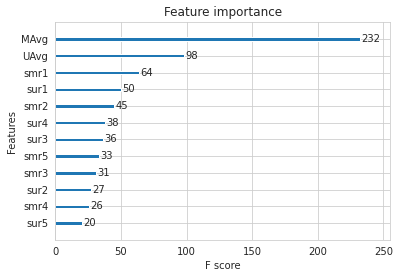

In [0]:
# prepare Train data
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# initialize Our first XGBoost model...
first_xgb = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['first_algo'] = train_results
models_evaluation_test['first_algo'] = test_results

xgb.plot_importance(first_xgb)
plt.show()

#Suprise BaselineModel

In [0]:
from surprise import BaselineOnly 

In [0]:
# options are to specify.., how to compute those user and item biases
bsl_options = {'method': 'sgd',
               'learning_rate': .001
               }
bsl_algo = BaselineOnly(bsl_options=bsl_options)
# run this algorithm.., It will return the train and test results..
bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset, verbose=True)


# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['bsl_algo'] = bsl_train_results 
models_evaluation_test['bsl_algo'] = bsl_test_results

Training the model...
Estimating biases using sgd...
Done. time taken : 0:00:00.288650 

Evaluating the model with train data..
time taken : 0:00:00.375395
---------------
Train Data
---------------
RMSE : 0.8842072876968495

MAPE : 31.146691282320088

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.168244
---------------
Test Data
---------------
RMSE : 0.9605481374984647

MAPE : 32.81865916434452

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:00.834467


#XGBoost with initial 13 features + Surprise Baseline predictor

In [0]:
# add that baseline predicted ratings with Surprise to the test data as well
reg_test_df['bslpr']  = models_evaluation_test['bsl_algo']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,328,1,3.522809,3.5,3.5,3.5,3.5,3.5,5.0,4.5,3.0,4.5,4.0,3.522809,3.871795,5.0,3.819211
1,330,1,3.522809,3.5,3.5,3.5,3.5,3.5,5.0,4.5,3.0,4.5,4.0,3.522809,3.871795,4.0,3.819211


In [0]:
# add our baseline_predicted value as our feature..
reg_train['bslpr'] = models_evaluation_train['bsl_algo']['predictions']
reg_train.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,1,1,3.522809,2.0,5.0,4.0,4.5,4.0,3.0,4.0,3.0,3.0,5.0,4.366379,3.871795,4.0,4.580116
1,5,1,3.522809,5.0,5.0,5.0,3.0,3.0,4.0,5.0,3.0,3.0,4.0,3.636364,3.871795,4.0,4.199442


Training the model..
[18:25:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:00:02.649873

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  0.96517376211804
MAPE :  31.81237288798757


<IPython.core.display.Javascript object>

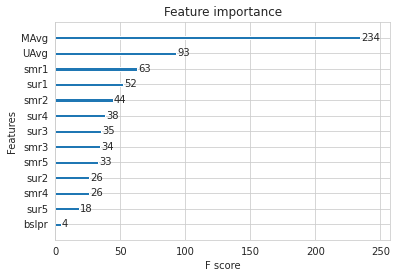

In [0]:
# prepare train data
x_train = reg_train.drop(['user', 'movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# initialize Our first XGBoost model...
xgb_bsl = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(xgb_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_bsl'] = train_results
models_evaluation_test['xgb_bsl'] = test_results

xgb.plot_importance(xgb_bsl)
plt.show()

#Surprise KNNBaseline predictor

In [0]:
from surprise import KNNBaseline

 Surprise KNNBaseline with user user similarities

In [0]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm
sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'} 

knn_bsl_u = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_u_train_results, knn_bsl_u_test_results = run_surprise(knn_bsl_u, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_u'] = knn_bsl_u_train_results 
models_evaluation_test['knn_bsl_u'] = knn_bsl_u_test_results


Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:00.350169 

Evaluating the model with train data..
time taken : 0:00:03.159148
---------------
Train Data
---------------
RMSE : 0.24888260888837116

MAPE : 7.138541598429198

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.317842
---------------
Test Data
---------------
RMSE : 0.9342048075092758

MAPE : 31.71710505158632

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:03.827856


Surprise KNNBaseline with movie movie similarities

In [0]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm

# 'user_based' : Fals => this considers the similarities of movies instead of users
#this didnt run in google coalb due to memory error

'''sim_options = {'user_based' : False,
               'name': 'cosine',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'}


knn_bsl_m = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)

knn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn_bsl_m, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results 
models_evaluation_test['knn_bsl_m'] = knn_bsl_m_test_results'''


"sim_options = {'user_based' : False,\n               'name': 'cosine',\n               'shrinkage': 100,\n               'min_support': 2\n              } \n# we keep other parameters like regularization parameter and learning_rate as default values.\nbsl_options = {'method': 'sgd'}\n\n\nknn_bsl_m = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)\n\nknn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn_bsl_m, trainset, testset, verbose=True)\n\n# Just store these error metrics in our models_evaluation datastructure\nmodels_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results \nmodels_evaluation_test['knn_bsl_m'] = knn_bsl_m_test_results"

#XGBoost with initial 13 features + Surprise Baseline predictor + KNNBaseline predictor

In [0]:
# add the predicted values from both knns to this dataframe
reg_train['knn_bsl_u'] = models_evaluation_train['knn_bsl_u']['predictions']


reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u
0,1,1,3.522809,2.0,5.0,4.0,4.5,4.0,3.0,4.0,3.0,3.0,5.0,4.366379,3.871795,4.0,4.580116,4.306792
1,5,1,3.522809,5.0,5.0,5.0,3.0,3.0,4.0,5.0,3.0,3.0,4.0,3.636364,3.871795,4.0,4.199442,4.026613


In [0]:
reg_test_df['knn_bsl_u'] = models_evaluation_test['knn_bsl_u']['predictions']


reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u
0,328,1,3.522809,3.5,3.5,3.5,3.5,3.5,5.0,4.5,3.0,4.5,4.0,3.522809,3.871795,5.0,3.819211,3.877139
1,330,1,3.522809,3.5,3.5,3.5,3.5,3.5,5.0,4.5,3.0,4.5,4.0,3.522809,3.871795,4.0,3.819211,3.877139


Training the model..
[18:26:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:00:02.752800

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  0.9666694938267869
MAPE :  31.860121260090672


<IPython.core.display.Javascript object>

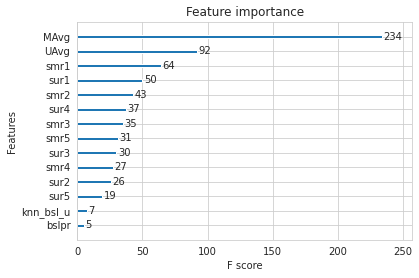

In [0]:
# prepare the train data....
x_train = reg_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = reg_train['rating']

# prepare the train data....
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# declare the model
xgb_knn_bsl = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_knn_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_knn_bsl'] = train_results
models_evaluation_test['xgb_knn_bsl'] = test_results


xgb.plot_importance(xgb_knn_bsl)
plt.show()

#Matrix Factorization Techniques

SVD Matrix Factorization User Movie intractions 

In [0]:
from surprise import SVD

In [0]:
# initiallize the model
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results

Training the model...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Done. time taken : 0:00:02.953667 

Evaluating the model with train data..
time taken : 0:00:00.452610
---------------
Train Data
---------------
RMSE : 0.6398224413088391

MAPE : 21.716375231974403

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.276759
---------------
Test Data
---------------
RMSE : 0.9359796762581933

MAPE : 31.799225163788797

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:03.685080


SVD Matrix Factorization with implicit feedback from user ( user rated movies )

In [0]:
from surprise import SVDpp

In [0]:
# initiallize the model
svdpp = SVDpp(n_factors=50, random_state=15, verbose=True)
svdpp_train_results, svdpp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svdpp'] = svdpp_train_results 
models_evaluation_test['svdpp'] = svdpp_test_results

Training the model...
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
Done. time taken : 0:08:18.147071 

Evaluating the model with train data..
time taken : 0:00:19.771467
---------------
Train Data
---------------
RMSE : 0.5594828118401755

MAPE : 18.078798682330632

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.192500
---------------
Test Data
---------------
RMSE : 0.9396045891407944

MAPE : 31.847282296149658

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:08:38.113350


#XgBoost with 13 features + Surprise Baseline + Surprise KNNbaseline + MF Techniques

In [0]:
# add the predicted values from both knns to this dataframe
reg_train['svd'] = models_evaluation_train['svd']['predictions']
reg_train['svdpp'] = models_evaluation_train['svdpp']['predictions']

reg_train.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,svd,svdpp
0,1,1,3.522809,2.0,5.0,4.0,4.5,4.0,3.0,4.0,3.0,3.0,5.0,4.366379,3.871795,4.0,4.580116,4.306792,4.623534,4.409466
1,5,1,3.522809,5.0,5.0,5.0,3.0,3.0,4.0,5.0,3.0,3.0,4.0,3.636364,3.871795,4.0,4.199442,4.026613,4.127527,4.114875


In [0]:
reg_test_df['svd'] = models_evaluation_test['svd']['predictions']
reg_test_df['svdpp'] = models_evaluation_test['svdpp']['predictions']

reg_test_df.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,svd,svdpp
0,328,1,3.522809,3.5,3.5,3.5,3.5,3.5,5.0,4.5,3.0,4.5,4.0,3.522809,3.871795,5.0,3.819211,3.877139,3.880769,3.772615
1,330,1,3.522809,3.5,3.5,3.5,3.5,3.5,5.0,4.5,3.0,4.5,4.0,3.522809,3.871795,4.0,3.819211,3.877139,3.880769,3.772615


Training the model..
[18:36:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:00:03.279300

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  0.9669869729398322
MAPE :  31.865710850609506


<IPython.core.display.Javascript object>

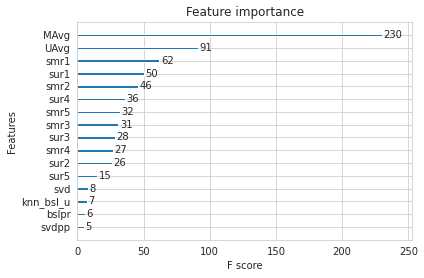

In [0]:
# prepare x_train and y_train
x_train = reg_train.drop(['user', 'movie', 'rating',], axis=1)
y_train = reg_train['rating']

# prepare test data
x_test = reg_test_df.drop(['user', 'movie', 'rating'], axis=1)
y_test = reg_test_df['rating']



xgb_final = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_final, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_final'] = train_results
models_evaluation_test['xgb_final'] = test_results


xgb.plot_importance(xgb_final)
plt.show()

#XgBoost with Surprise Baseline + Surprise KNNbaseline + MF Techniques 

Training the model..
[18:36:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:00:01.928218

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0073565416713817
MAPE :  33.92468038300662


<IPython.core.display.Javascript object>

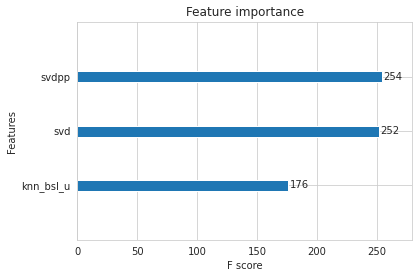

In [0]:
# prepare train data
x_train = reg_train[['knn_bsl_u', 'svd', 'svdpp']]
y_train = reg_train['rating']

# test data
x_test = reg_test_df[['knn_bsl_u', 'svd', 'svdpp']]
y_test = reg_test_df['rating']


xgb_all_models = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_all_models, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_all_models'] = train_results
models_evaluation_test['xgb_all_models'] = test_results

xgb.plot_importance(xgb_all_models)
plt.show()

##Final results

In [0]:
# Saving our TEST_RESULTS into a dataframe so that you don't have to run it again
pd.DataFrame(models_evaluation_test).to_csv('small_sample_results.csv')
models = pd.read_csv('small_sample_results.csv', index_col=0)
models.loc['rmse'].sort_values()

knn_bsl_u         0.9342048075092758
svd               0.9359796762581933
svdpp             0.9396045891407944
bsl_algo          0.9605481374984647
xgb_bsl             0.96517376211804
xgb_knn_bsl       0.9666694938267869
first_algo        0.9667854004586138
xgb_final         0.9669869729398322
xgb_all_models    1.0073565416713817
Name: rmse, dtype: object